In [2]:
from pynblast import NblastArena, Idx, ScoreMatrix
from typing import Tuple, List, Dict
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
DATA_DIR = Path().resolve().parent / "data"
POINTS_DIR = DATA_DIR / "points"

In [4]:
smat = ScoreMatrix.read(DATA_DIR / "smat_jefferis.csv")
print(smat.to_df())

             0.1        0.2        0.3        0.4        0.5       0.6  \
0.75    9.500097   9.215083   9.211151   8.778460   9.164808  9.226703   
1.50    8.447755   9.046068   8.667959   8.620981   8.776275  8.991697   
2.00    7.814143   8.275576   8.186607   8.237314   8.155985  8.449821   
2.50    7.516167   7.681555   7.825236   7.793659   7.886876  8.031765   
3.00    6.978315   6.943078   7.079218   7.049651   7.213063  6.938749   
3.50    6.337199   6.510450   6.357374   6.730668   6.641336  6.684943   
4.00    5.734997   5.776564   5.874881   6.078469   6.024177  5.936485   
5.00    5.115815   5.021649   5.156575   5.104265   5.140931  5.108691   
6.00    4.233995   4.157948   4.207282   4.154590   4.126861  4.073368   
7.00    3.340269   3.305132   3.295987   3.260452   3.292369  3.178867   
8.00    2.495160   2.520984   2.523058   2.469504   2.482756  2.495894   
9.00    1.802393   1.781095   1.706758   1.775359   1.752899  1.751467   
10.00   1.232041   1.249022   1.150560

In [5]:
def read_points(fpath: Path):
    return pd.read_csv(fpath, index_col=0, header=0).to_numpy()


def read_all_points(dpath: Path, recursive=False):
    glob = "*.csv"
    if recursive:
        glob = "**/" + glob
    for fpath in dpath.glob(glob):
        yield fpath.stem, read_points(fpath)
    

In [6]:
arena = NblastArena(*smat)

name_to_idx = dict()
for name, arr in read_all_points(DATA_DIR / "points"):
    name_to_idx[name] = arena.add_points(arr)
    

In [7]:
def all_v_all_df(results, name_to_idx):
    names = list(name_to_idx)
    length = len(name_to_idx)
    df = pd.DataFrame(index=names, columns=names)
    df.index.rename("query", inplace=True)
    df.columns.rename("target", inplace=True)
    for (row, col), val in results.items():
        df.iloc[row, col] = val
    return df

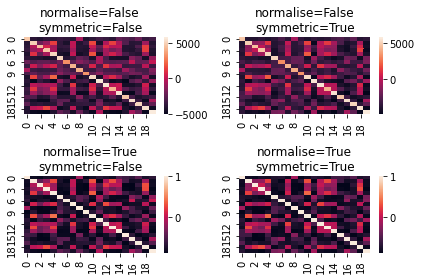

In [8]:
fig, ax_arr = plt.subplots(2, 2)
ax_lst = list(ax_arr.flatten())

all_results = dict()

for ax, (normalise, symmetric) in zip(
    ax_lst, itertools.product([False, True], repeat=2),
):
    df = all_v_all_df(arena.all_v_all(normalise, symmetric), name_to_idx)
    all_results[(normalise, symmetric)] = df
    sns.heatmap(df.to_numpy().astype(float), ax=ax)
    ax.set_title(f"normalise={normalise}\nsymmetric={symmetric}")

fig.tight_layout()

In [15]:
basic = all_results[(False, False)]
print(f"{np.sum(basic.to_numpy() < 0) / basic.size} is <0")
#print(all_results[(False, False)])

0.8525 is <0


In [9]:
dists = 1 - all_results[(True, True)]
condensed = squareform(dists)
linkage_arr = linkage(condensed)

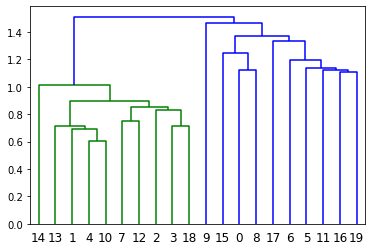

In [10]:
dn = dendrogram(linkage_arr)